# Kernel CCA (KCCA)

This algorithm runs KCCA on two views of data. The kernel implementations, parameter 'ktype', are linear, polynomial and gaussian. Polynomial kernel has two parameters: 'constant', 'degree'. Gaussian kernel has one parameter: 'sigma'.

When initializing KCCA, you can also initialize the following parameters: the number of canonical components 'n_components', the regularization parameter 'reg', the decomposition type 'decomposition', and the decomposition method 'method'. There are two decomposition types: 'full' and 'icd'. In some cases, ICD will run faster than the full decomposition at the cost of performance. The only method as of now is 'kettenring-like'.

In [1]:
import numpy as np
import sys
sys.path.append("../../..")

from mvlearn.embed.kcca import KCCA
from mvlearn.plotting.plot import crossviews_plot
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

/Users/theodorelee/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


Function creates Xs, a list of two views of data with a linear relationship, polynomial relationship (2nd degree) and a gaussian (sinusoidal) relationship.

In [2]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

## Linear kernel implementation

Here we show how KCCA with a linear kernel can uncover the highly correlated latent distribution of the 2 views which are related with a linear relationship, and then transform the data into that latent space. We use an 80-20, train-test data split to develop the embedding. 

We also use Incomplete Cholesky Decomposition (rank 50) by fitting and transforming on all of the data.

In [3]:
np.random.seed(1)
Xs = make_data('linear', 100)
Xs_train = [Xs[0][:80],Xs[1][:80]]
Xs_test = [Xs[0][80:],Xs[1][80:]]

kcca_l = KCCA(n_components = 4, reg = 0.01)
kcca_l.fit(Xs_train)
linearkcca = kcca_l.transform(Xs_test)

### Original Data Plotted

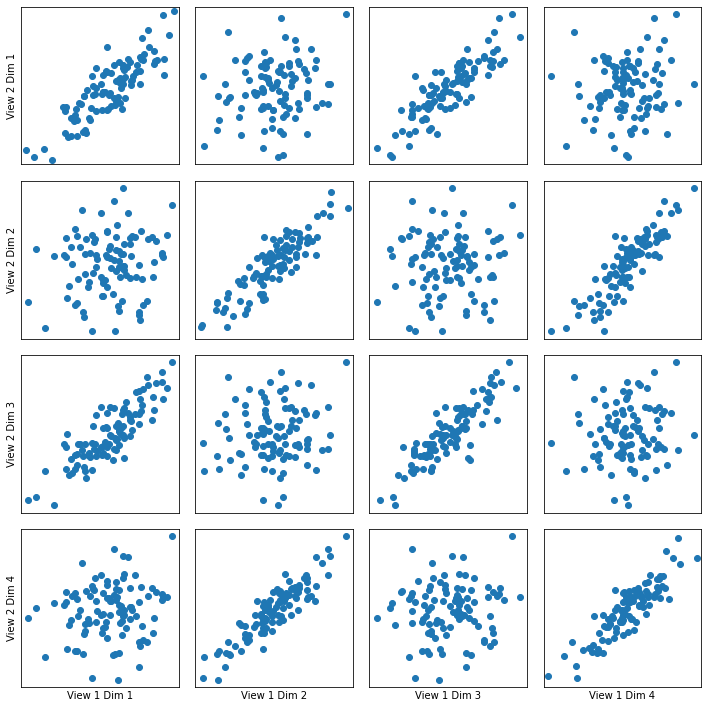

In [4]:
crossviews_plot(Xs, ax_ticks=False, ax_labels=True, equal_axes=True)

### Transformed Data Plotted

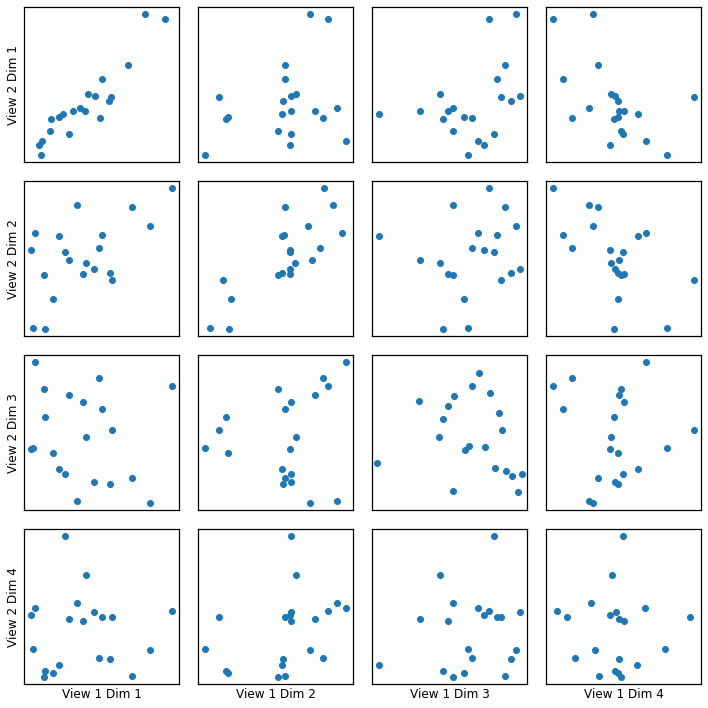

In [5]:
crossviews_plot(linearkcca, ax_ticks=False, ax_labels=True, equal_axes=True)

In [6]:
(r1, _) = stats.pearsonr(linearkcca[0][:,0], linearkcca[1][:,0])
(r2, _) = stats.pearsonr(linearkcca[0][:,1], linearkcca[1][:,1])
(r3, _) = stats.pearsonr(linearkcca[0][:,2], linearkcca[1][:,2])
(r4, _) = stats.pearsonr(linearkcca[0][:,3], linearkcca[1][:,3])

print("Below are the canonical correlation for the four components:")
print(r1,r2,r3,r4)

Below are the canonical correlation for the four components:
0.9236525471102431 0.7941944421474335 -0.24534869752186572 -0.0035017031081538723


## Incomplete Cholesky Decomposition

In [19]:
kcca_l_icd = KCCA(ktype ="linear", sigma = 1.0, n_components = 4, reg = 0.01, decomp = 'icd', mrank = 50)
icd_l = kcca_l_icd.fit_transform(Xs)

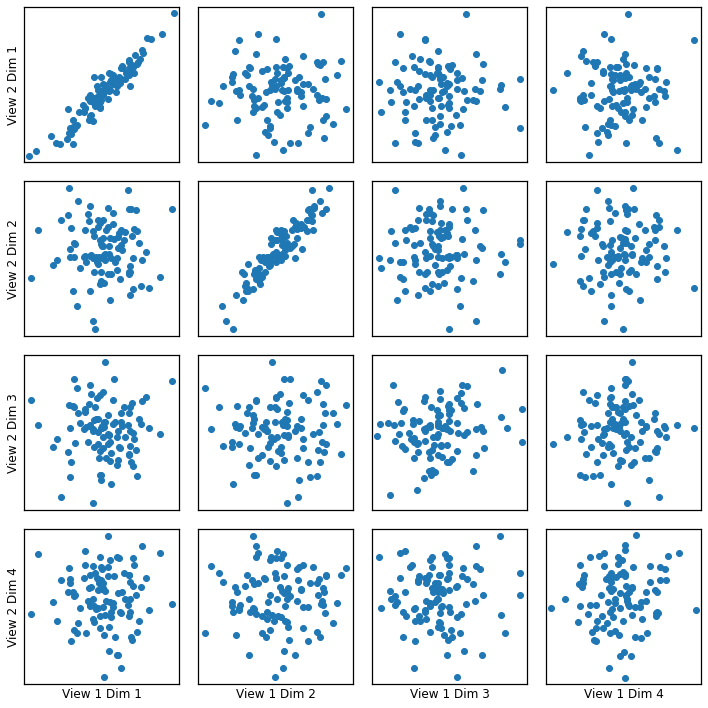

In [20]:
crossviews_plot(icd_l, ax_ticks=False, ax_labels=True, equal_axes=True)

In [21]:
(icd_l_r1, _) = stats.pearsonr(icd_l[0][:,0], icd_l[1][:,0])
(icd_l_r2, _) = stats.pearsonr(icd_l[0][:,1], icd_l[1][:,1])

print("Below are the canonical correlation of the first two components:")
print(icd_l_r1,icd_l_r2)

Below are the canonical correlation of the first two components:
0.9531566404112796 0.9246106136040633


## Polynomial kernel implementation

Here we show how KCCA with a polynomial kernel can uncover the highly correlated latent distribution of the 2 views which are related with a polynomial relationship, and then transform the data into that latent space.

In [7]:
Xsp = make_data("poly", 150)
kcca_p = KCCA(ktype ="poly", degree = 2.0, n_components = 4, reg=0.001)
polykcca = kcca_p.fit_transform(Xsp)

### Original Data Plotted

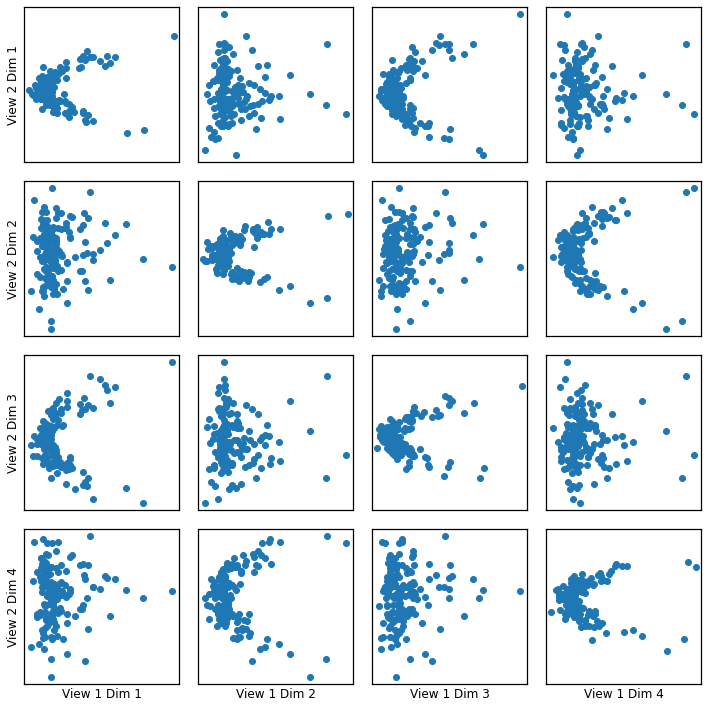

In [8]:
crossviews_plot(Xsp, ax_ticks=False, ax_labels=True, equal_axes=True)

### Transformed Data Plotted

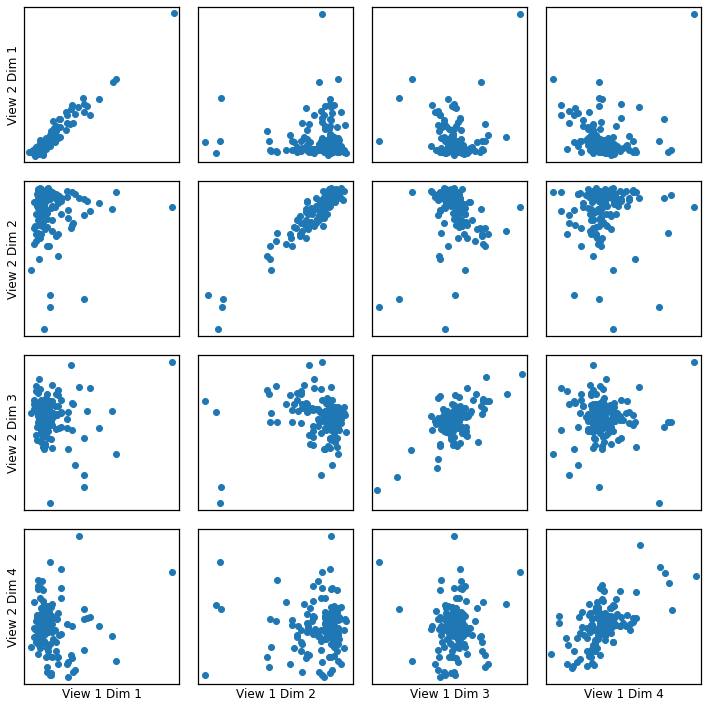

In [9]:
crossviews_plot(polykcca, ax_ticks=False, ax_labels=True, equal_axes=True)

In [10]:
(pr1, _) = stats.pearsonr(polykcca[0][:,0], polykcca[1][:,0])
(pr2, _) = stats.pearsonr(polykcca[0][:,1], polykcca[1][:,1])
(pr3, _) = stats.pearsonr(polykcca[0][:,2], polykcca[1][:,2])
(pr4, _) = stats.pearsonr(polykcca[0][:,3], polykcca[1][:,3])


print("Below are the canonical correlation for the two components:")
print(pr1,pr2,pr3,pr4)

Below are the canonical correlation for the two components:
0.9673839623915123 0.945002846313366 0.6333492148127364 0.5787082007398375


## Gaussian Kernel Implementation

Here we show how KCCA with a gaussian kernel can uncover the highly correlated latent distribution of the 2 views which are related with a sinusoidal relationship, and then transform the data into that latent space. We also implement the Incomplete Cholesky decomposition method on the same views and compare performance with the full decomposition method.

In [11]:
Xsg = make_data("gaussian", 100)
Xsg_train = [Xsg[0][:20],Xsg[1][:20]]
Xsg_test = [Xsg[0][20:],Xsg[1][20:]]

In [12]:
kcca_g = KCCA(ktype ="gaussian", sigma = 3.0, n_components = 2, reg = 0.01)
kcca_g.fit(Xsg)
gausskcca = kcca_g.transform(Xsg)

### Original Data Plotted

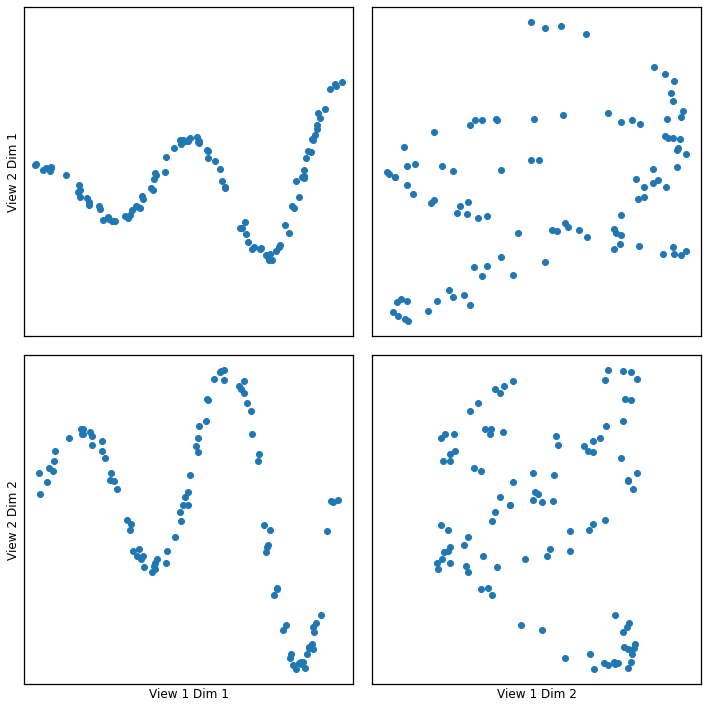

In [13]:
crossviews_plot(Xsg, ax_ticks=False, ax_labels=True, equal_axes=True)

### Transformed Data Plotted

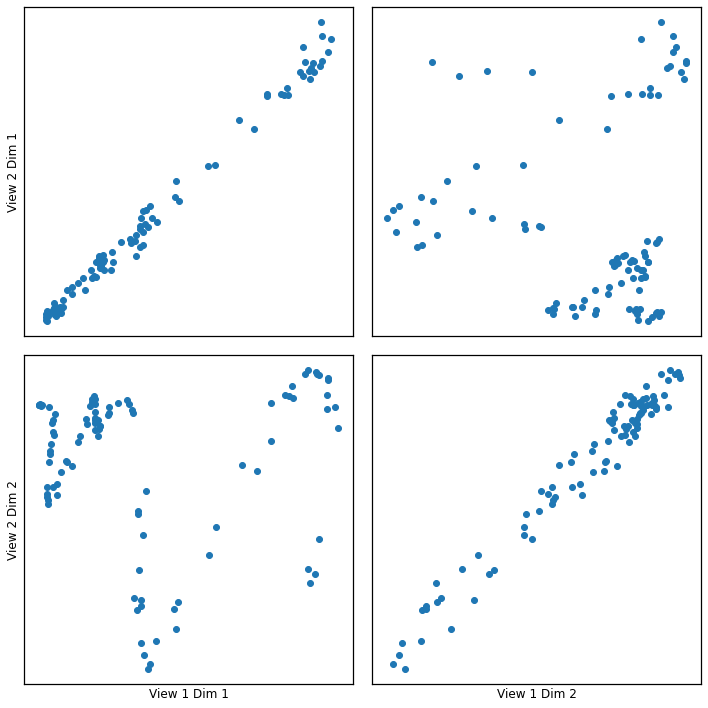

In [14]:
crossviews_plot(gausskcca, ax_ticks=False, ax_labels=True, equal_axes=True)

In [15]:
(gr1, _) = stats.pearsonr(gausskcca[0][:,0], gausskcca[1][:,0])
(gr2, _) = stats.pearsonr(gausskcca[0][:,1], gausskcca[1][:,1])

print("Below are the canonical correlation of the two components:")
print(gr1,gr2)

Below are the canonical correlation of the two components:
0.995272250571659 0.9823764035712218


## Incomplete Cholesky Decomposition

In [16]:
kcca_g_icd = KCCA(ktype ="gaussian", sigma = 1.0, n_components = 2, reg = 0.01, decomp = 'icd', mrank = 50)
icd = kcca_g_icd.fit_transform(Xsg)

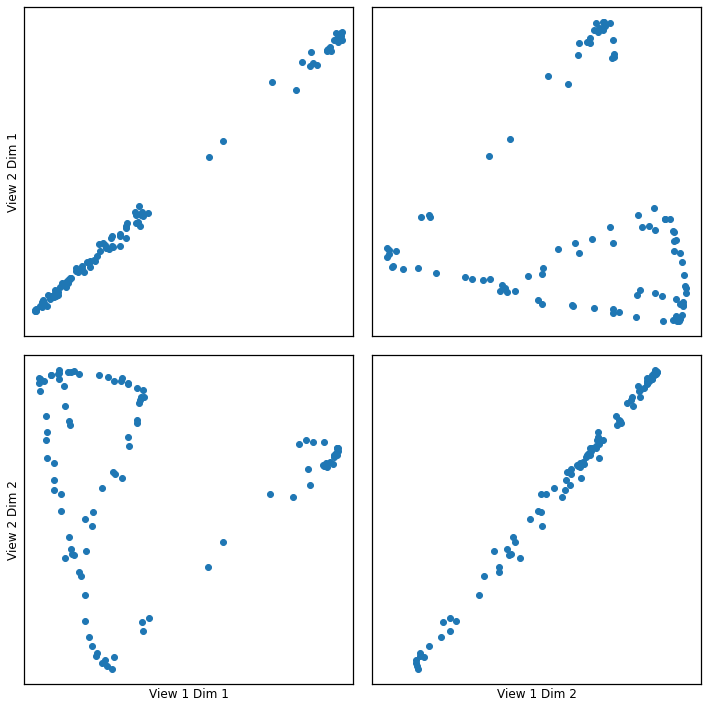

In [17]:
crossviews_plot(icd, ax_ticks=False, ax_labels=True, equal_axes=True)

In [18]:
(icdr1, _) = stats.pearsonr(icd[0][:,0], icd[1][:,0])
(icdr2, _) = stats.pearsonr(icd[0][:,1], icd[1][:,1])

print("Below are the canonical correlation of the two components:")
print(icdr1,icdr2)

Below are the canonical correlation of the two components:
0.9988723783302298 0.9976275126057713
